In [1]:
# plot
%matplotlib inline
%matplotlib widget
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

# basic packages
import numpy as np
import pandas as pd
import json
import pickle
from tqdm import tqdm
import math

# acceleration
from numba import jit, njit


# learning packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.preprocessing import normalize
from lightgbm import LGBMModel, LGBMClassifier, LGBMRegressor, plot_importance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Load preprocessed data

In [2]:
"""
load preprocessed data (train_feature_sklearn didn't perform well)
"""

with open('preprocessed_data/efedericisentence_bert_base/train_feature.json') as f:
    training_data = json.load(f)
# with open('preprocessed_data/efedericisentence_bert_base/train_feature_sklearn.json') as f:
#     training_data = json.load(f)

training_id = [int(data['id']) for data in training_data]
X = [data['feature'] for data in training_data]
X = np.asarray(X, dtype=np.float32)
Y = np.asarray([int(data['label']) for data in training_data])


with open('preprocessed_data/efedericisentence_bert_base/test_feature.json') as f:
    testing_data = json.load(f)
# with open('preprocessed_data/efedericisentence_bert_base/test_feature_sklearn.json') as f:
#     testing_data = json.load(f)

testing_id = [int(data['id']) for data in testing_data]
X_test = [data['feature'] for data in testing_data]
X_test = np.asarray(X_test, dtype=np.float32)

# Normalization or not

In [71]:
# without normalization
# X_train, X_eval, Y_train, Y_eval = train_test_split(X, Y, test_size=0.33, random_state=8787)

In [57]:
# normalize data
X_norm = normalize(X, axis=0, norm='max')
X_test_norm = normalize(X_test, axis=0, norm='max')

# splt a validation set from the training set
X_train, X_eval, Y_train, Y_eval = train_test_split(X_norm, Y, test_size=0.33, random_state=8787)

In [5]:
X.shape

(17170, 5393)

# AdaBoost

In [58]:
# keep this to ensemble
ada_model = AdaBoostClassifier()
# model = AdaBoostRegressor()
ada_model = ada_model.fit(X_train, Y_train)

# classifier
# [7 2 6 2 8 6 1 0 3 9]
# [6, 8, 5, 6, 5, 7, 2, 0, 6, 5]
# 1.892182812775719 without normalization
# 1.8898888300688195 normalize(X, axis=0, norm='l2')
# 1.9897653079230633 normalize(X, axis=0, norm='l1')
# 1.892182812775719 normalize(X, axis=0, norm='max')
# 1.9467090171166401 normalize(X, axis=0, norm='max') + sklearn

# regressor (regressor is bad and for ensemble also)
# [5.46871795 4.78809981 4.73425911 5.26485693 5.42580422 4.69496718
#  3.72908036 3.32583367 3.89906542 5.26296543]
# [6, 8, 5, 6, 5, 7, 2, 0, 6, 5]
# 2.04174423537671
# 2.03731505705575 normalize(X, axis=0, norm='max')

In [76]:
# Validation
ada_pred = ada_model.predict(X_eval)
print(ada_pred[:10])
print(Y_eval[:10])
print(np.mean(np.abs(ada_pred - Y_eval)))

[2 7 0 7 3 3 2 0 0 0]
[6 8 5 6 5 7 2 0 6 5]
3.018881242279866


# LightGBM Random Forest

In [8]:
# lgbm_rf_model = LGBMRegressor(n_estimators=25000,
#                             verbose=1,
#                             n_jobs=10,
#                             feature_fraction=0.3,
#                             bagging_fraction=0.4,
#                             bagging_freq=10,
#                             random_state=1234,
#                             boosting_type='rf',
#                             metric='mae',)

# lgbm_rf_model.fit(X_train,Y_train)
with open(f'model/lgbm_rf_model_1.975083351596476.pickle', 'rb') as f:
    lgbm_rf_model = pickle.load(f)

In [9]:
# Validation random forest
rf_pred = lgbm_rf_model.predict(X_eval)
print(rf_pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(rf_pred - Y_eval))
print(np.mean(np.abs(rf_pred - Y_eval)))

# with open(f'model/lgbm_rf_model_{mae}.pickle', 'wb') as f:
#     pickle.dump(lgbm_rf_model, f)

[5.91675866 4.85540791 3.2167997  5.19552498 5.36386897 5.09967925
 4.87556655 2.98733239 3.48268964 4.79778757]
[6 8 5 6 5 7 2 0 6 5]
1.975083351596476


# LightGBM dart

In [10]:
# lgbm_dart_model = LGBMRegressor(n_estimators=25000,
#                             verbose=1,
#                             n_jobs=10,
#                             feature_fraction=0.3,
#                             bagging_fraction=0.4,
#                             bagging_freq=10,
#                             random_state=1234,
#                             boosting_type='dart',
#                             metric='mae',)

# lgbm_dart_model.fit(X_train,Y_train)

with open(f'model/lgbm_dart_model_1.5051226027983768.pickle', 'rb') as f:
    lgbm_dart_model = pickle.load(f)

In [11]:
# Validation random forest
dart_pred = lgbm_dart_model.predict(X_eval)
print(dart_pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(dart_pred - Y_eval))
print(np.mean(np.abs(dart_pred - Y_eval)))

# with open(f'model/lgbm_dart_model_{mae}.pickle', 'wb') as f:
#     pickle.dump(lgbm_dart_model, f)

[ 6.07637946  4.8815205   5.08575302  4.39460047  5.02208222  5.25590233
  2.86624757 -0.13714061  3.6375148   5.39204124]
[6 8 5 6 5 7 2 0 6 5]
1.5051226027983768


# MLP

In [12]:
MLP_model = MLPClassifier(random_state=8787, max_iter=300, solver='lbfgs')
MLP_model = MLP_model.fit(X_train, Y_train)
MLP_pred = MLP_model.predict(X_eval)

print(MLP_pred[:10])
print(Y_eval[:10])
print(np.mean(np.abs(MLP_pred - Y_eval)))

# MLPClassifier
# 2.3103935062643375 normalize(X, axis=0, norm='max')
# 2.29257102523381 normalize(X, axis=0, norm='max') solver='lbfgs'

# MLPRegressor
# 2.113751735361413 normalize(X, axis=0, norm='max')
# 2.121090104958476 normalize(X, axis=0, norm='max') solver='lbfgs'

[5 3 3 8 3 1 6 2 5 6]
[6 8 5 6 5 7 2 0 6 5]
2.29257102523381


# LightGBM gbdt

In [13]:
# params = {
#     "n_estimators": 20000,
#     "verbose": 1,
#     "n_jobs": 10,
#     "feature_fraction": 0.3,
#     "bagging_fraction": 0.4,
#     "random_state": 8787,
#     "num_leaves": 128,
#     "max_depth": 10,
#     "max_bin": 400,
#     "boosting_type": "gbdt",
#     "metric": "mae"
# }

# lgbm_model = LGBMRegressor(**params)


# lgbm_model = LGBMClassifier(n_estimators=2500,
#                             verbose=1,
#                             n_jobs=10,
#                             feature_fraction=0.3,
#                             bagging_fraction=0.4,
#                             random_state=1234,
#                             boosting_type='gbdt',
#                             objective='multiclass',
#                             metric='multi_logloss',
#                             num_class=10,
#                             )


lgbm_model = LGBMRegressor(n_estimators=2500,
                            verbose=1,
                            n_jobs=10,
                            feature_fraction=0.3,
                            bagging_fraction=0.4,
                            random_state=1234,
                            boosting_type='gbdt',
                            metric='mae',
                            )

lgbm_model.fit(X_train,Y_train)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.331829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088680
[LightGBM] [Info] Number of data points in the train set: 11503, number of used features: 5393
[LightGBM] [Info] Start training from score 4.578719


LGBMRegressor(bagging_fraction=0.4, feature_fraction=0.3, metric='mae',
              n_estimators=2500, n_jobs=10, random_state=1234, verbose=1)

In [50]:
# Validation
pred = lgbm_model.predict(X_eval)
print(pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(pred - Y_eval))
print(np.mean(np.abs(pred - Y_eval)))

# with open(f'model/lgbm_model_{mae}.pickle', 'wb') as f:
#     pickle.dump(lgbm_model, f)



# 1.5281773604910713 normalize(X, axis=0, norm='l2')
# 1.524419374799644 normalize(X, axis=0, norm='max')
# 1.5378436521960257 sklearn without norm

[ 6.36401533  4.47020014  5.36117254  4.74674159  5.58729913  5.56210735
  4.04374254 -0.0363413   3.73273524  5.68358393]
[6 8 5 6 5 7 2 0 6 5]
1.5244193747996395


# Label clean

In [75]:
dart_pred = lgbm_dart_model.predict(X_eval)

for i, label in enumerate(dart_pred):
    if dart_pred[i] < 0:
        dart_pred[i] = 0
    elif dart_pred[i] > 9:
        dart_pred[i] = 9
    
    # pred[i] = np.round(pred[i])

print(dart_pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(dart_pred - Y_eval))
mae

[3.76862358 3.99209766 3.76347483 4.21740341 3.52869908 4.69795099
 1.55853504 1.5560683  2.90730365 2.23493054]
[6 8 5 6 5 7 2 0 6 5]


2.1163363377548645

In [74]:
pred = lgbm_model.predict(X_eval)

for i, label in enumerate(pred):
    if pred[i] < 0:
        pred[i] = 0
    elif pred[i] > 9:
        pred[i] = 9
    
    # pred[i] = np.round(pred[i])

print(pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(pred - Y_eval))
mae


[4.73321621 2.42612558 4.22263051 4.27568113 2.42580195 3.98104733
 3.35372922 1.72234893 2.03650581 2.08579924]
[6 8 5 6 5 7 2 0 6 5]


2.1651215788984968

In [73]:
# You don't need to process this actually
ada_pred = ada_model.predict(X_eval)

print(ada_pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(ada_pred - Y_eval))
mae

[2 7 0 7 3 3 2 0 0 0]
[6 8 5 6 5 7 2 0 6 5]


3.018881242279866

# Linear Search for best weights combo

In [34]:
@jit
def LinearSearch(pred1, pred2, pred3, Y_eval, if_clean:dict):

    # init search grid
    model1_w = np.arange(1, 100, 1)
    # model2_w = np.arange(1, 100, 1)
    model2_w = [0]
    model3_w = np.arange(1, 100, 1)
    
    
    if if_clean['model1']:
        for i, label in enumerate(pred1):
            if pred1[i] < 0:
                pred1[i] = 0
            elif pred1[i] > 9:
                pred1[i] = 9
            
            if if_clean['model1_round']:
                pred1[i] = np.round(pred1[i])
                
    if if_clean['model2']:
        for i, label in enumerate(pred2):
            if pred2[i] < 0:
                pred2[i] = 0
            elif pred2[i] > 9:
                pred2[i] = 9
            
            if if_clean['model2_round']:
                pred2[i] = np.round(pred2[i])
                
    if if_clean['model3']:
        for i, label in enumerate(pred3):
            if pred3[i] < 0:
                pred3[i] = 0
            elif pred3[i] > 9:
                pred3[i] = 9
            
            if if_clean['model3_round']:
                pred3[i] = np.round(pred3[i])

    if_post_clean = [True, False]

    best_mae = 10
    best_weights = {
        'weight1': 0,
        'weight2': 0,
        'weight3': 0,
        'post_clean': False,
    }

    for w1 in model1_w:
        for w2 in model2_w:
            for w3 in model3_w:
                for post_clean in if_post_clean:
                    ensemble_pred = (w1*pred1 + w2*pred2 + w3*pred3) / np.sum([w1, w2, w3])
                    if post_clean:
                        for i, label in enumerate(ensemble_pred):
                            if ensemble_pred[i] < 0:
                                ensemble_pred[i] = 0
                            elif ensemble_pred[i] > 9:
                                ensemble_pred[i] = 9
                            
                            ensemble_pred[i] = np.round(ensemble_pred[i])
                            
                    mae = np.mean(np.abs(ensemble_pred - Y_eval))
                    if mae < best_mae:
                        best_mae = mae
                        best_weights['weight1'] = w1
                        best_weights['weight2'] = w2
                        best_weights['weight3'] = w3
                        best_weights['post_clean'] = post_clean
                        print(best_mae, best_weights)

                    
    return best_mae, best_weights

In [35]:
pred = lgbm_model.predict(X_eval)
dart_pred = lgbm_dart_model.predict(X_eval)
ada_pred = ada_model.predict(X_eval)
if_clean = {
    'model1': False,
    'model1_round': False,
    'model2': False,
    'model2_round': False,
    'model3': False,
    'model3_round': False,
}
mae, best_weights = LinearSearch(pred, dart_pred, ada_pred, Y_eval, if_clean)

# 1.4917946003176283 {'weight1': 1, 'weight2': 1, 'weight3': 1, 'post_clean': True}
# 1.482442209281807 {'weight1': 1, 'weight2': 2, 'weight3': 1, 'post_clean': True}
# 1.4776777836597847 {'weight1': 1, 'weight2': 3, 'weight3': 1, 'post_clean': True}
# 1.4722075172048703 {'weight1': 1, 'weight2': 4, 'weight3': 1, 'post_clean': True}
# 1.470972295747309 {'weight1': 2, 'weight2': 4, 'weight3': 1, 'post_clean': True}
# 1.4688547732486323 {'weight1': 2, 'weight2': 5, 'weight3': 1, 'post_clean': True}
# 1.4679724722075171 {'weight1': 3, 'weight2': 3, 'weight3': 1, 'post_clean': True}
# 1.4623257455443797 {'weight1': 4, 'weight2': 3, 'weight3': 1, 'post_clean': True}
# 1.4609140638785953 {'weight1': 13, 'weight2': 9, 'weight3': 3, 'post_clean': True}
# 1.4607376036703723 {'weight1': 69, 'weight2': 48, 'weight3': 16, 'post_clean': True}


C:\Users\tsai9\AppData\Local\Temp\ipykernel_33864\679994154.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "LinearSearch" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\tsai9\AppData\Local\Temp\ipykernel_33864\679994154.py (5)

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_33864\679994154.py", line 5:
<source missing, REPL/exec in use?>

  @jit
C:\Users\tsai9\AppData\Local\Temp\ipykernel_33864\679994154.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "LinearSearch" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_33864\679994154.py", line 32:
<source missing, REPL/exec in use?>

  @jit
c:\Users\tsai9\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "LinearSearch" was 

1.5498500088230105 {'weight1': 1, 'weight2': 0, 'weight3': 1, 'post_clean': True}
1.5032645138521263 {'weight1': 2, 'weight2': 0, 'weight3': 1, 'post_clean': True}
1.4949708840656433 {'weight1': 3, 'weight2': 0, 'weight3': 1, 'post_clean': True}
1.4854420328215987 {'weight1': 4, 'weight2': 0, 'weight3': 1, 'post_clean': True}
1.4810305276160225 {'weight1': 5, 'weight2': 0, 'weight3': 1, 'post_clean': True}
1.4806776071995764 {'weight1': 14, 'weight2': 0, 'weight3': 3, 'post_clean': True}
1.4803246867831303 {'weight1': 19, 'weight2': 0, 'weight3': 4, 'post_clean': True}


KeyboardInterrupt: 

In [72]:

ensemble_pred = (pred * 0.83 + ada_pred * 0.17)
# max_pred, min_pred = ensemble_pred.max(), ensemble_pred.min()
# ensemble_pred = 9 * (ensemble_pred - min_pred) / (max_pred - min_pred)

# for i, label in enumerate(ensemble_pred):
#     if ensemble_pred[i] < 0:
#         ensemble_pred[i] = 0
#     elif ensemble_pred[i] > 9:
#         ensemble_pred[i] = 9
    
# #     # elif np.abs(math.modf(ensemble_pred[i])[0] - 0.5) < 0.5:
#     ensemble_pred[i] = np.round(ensemble_pred[i])

print(ensemble_pred[:10])
print(Y_eval[:10])
mae = np.mean(np.abs(ensemble_pred - Y_eval))
mae

# 1.4805011469913534 lgbm no round remove >9 < 0 round after ensemble normalize(X, axis=0, norm='max') (pred * 0.84 + ada_pred * 0.16)

[ 6.47213272  4.05026612  5.46977321  4.27979552  5.99745828  5.6365491
  3.52630631 -0.03016328  3.60817025  6.24737466]
[6 8 5 6 5 7 2 0 6 5]


1.5073934355196208

# 10-fold cv

In [30]:
"""
10 fold cv to tune parameters
"""

# # k-fold example
# folds = 10
# RUNS = 1

# # parameter grid
# ff = np.arange(0.1, 1.0, 0.1) # 0.1 ~ 0.9
# bf = np.arange(0.1, 1.0, 0.1) # 0.1 ~ 0.9

# Y = np.asarray(Y)
# best_err = 100
# best_ff = 0.1
# best_bf = 0.1
# for i in range(RUNS):
#     for f in ff:
#         # for b in bf:
#         kf = KFold(n_splits=folds, random_state=np.random.randint(0, len(X)), shuffle=True)
#         err = 0
#         for k, (train_idx, valid_idx) in enumerate(kf.split(X)):
#             # use lower case(x, y)
#             x_train, x_valid = X[train_idx], X[valid_idx]
#             y_train, y_valid = Y[train_idx], Y[valid_idx]

#             lgbm_model = LGBMRegressor(n_estimators=2500,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 feature_fraction=f,
#                                 bagging_fraction=0.4,
#                                 random_state=1234,
#                                 boosting_type='gbdt',
#                                 # objective='multiclass',
#                                 # metric='multi_logloss',
#                                 metric='mae',
#                                 # num_class=10,
#                                 )

#             lgbm_model.fit(x_train,y_train)
            
#             pred = lgbm_model.predict(x_valid)
#             # print(pred[:10])
#             # print(y_valid[:10])
#             err += sum(np.abs(pred - y_valid))/len(y_valid)
#         mean_mae = err/folds
#         print(f'10-fold mean mae: {mean_mae}')
#         if best_err > mean_mae:
#             best_err = err/folds
#             best_ff = f
            # best_bf = b

# cost almost 400 minutes to do 10fold cv only for one parameter (feature_fraction)
# maybe directly use a small valid set is better. (save a lot of time)
# best f = 0.8 (overfitting)
# best 10 fold mean mae = 1.486365996626446

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1092400
[LightGBM] [Info] Number of data points in the train set: 15453, number of used features: 5393
[LightGBM] [Info] Start training from score 4.598007
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

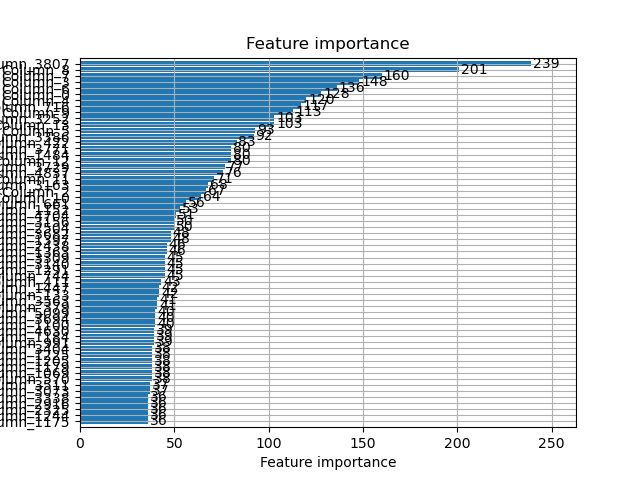

In [37]:
plot_importance(lgbm_model, max_num_features = 60, height=.9)

# Feed All data after validation (we can skip this part for now)

In [6]:
"""
train model with the whole training set
"""

# model = AdaBoostClassifier()
# model = model.fit(X, Y)


# lgbm_dart_model = LGBMRegressor(n_estimators=25000,
#                             verbose=1,
#                             n_jobs=10,
#                             feature_fraction=0.3,
#                             bagging_fraction=0.4,
#                             bagging_freq=10,
#                             random_state=1234,
#                             boosting_type='dart',
#                             metric='mae',)

# lgbm_dart_model.fit(X,Y)


# lgbm_model = LGBMRegressor(n_estimators=2500,
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 feature_fraction=0.3,
#                                 bagging_fraction=0.4,
#                                 random_state=1234,
#                                 boosting_type='gbdt',
#                                 metric='mae',
#                                 )

# lgbm_model.fit(X, Y)

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.561963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1092432
[LightGBM] [Info] Number of data points in the train set: 17170, number of used features: 5393
[LightGBM] [Info] Start training from score 4.586022


LGBMRegressor(bagging_fraction=0.4, feature_fraction=0.3, metric='mae',
              n_estimators=2500, random_state=1234, verbose=1)

In [59]:
# test
# pred_label_lgbm = lgbm_model.predict(X_test)
pred_label_lgbm = lgbm_model.predict(X_test_norm)

# for i, label in enumerate(pred_label_lgbm):
#     if pred_label_lgbm[i] < 0:
#         pred_label_lgbm[i] = 0
#     elif pred_label_lgbm[i] > 9:
#         pred_label_lgbm[i] = 9
    
#     pred_label_lgbm[i] = np.round(pred_label_lgbm[i])

# pred_label_dart = lgbm_dart_model.predict(X_test)
pred_label_dart = lgbm_dart_model.predict(X_test_norm)
# for i, label in enumerate(pred_label_dart):
#     if pred_label_dart[i] < 0:
#         pred_label_dart[i] = 0
#     elif pred_label_dart[i] > 9:
#         pred_label_dart[i] = 9
    
#     pred_label_dart[i] = np.round(pred_label_dart[i])

# pred_label_ada = model.predict(X_test)
pred_label_ada = ada_model.predict(X_test_norm)

# ensemble
# maybe we can apply gridsearch to find the best combo of weights
pred_label_ensemble = (pred_label_lgbm * 2 + pred_label_dart * 4 + pred_label_ada * 1)/7


for i, label in enumerate(pred_label_ensemble):
    if pred_label_ensemble[i] < 0:
        pred_label_ensemble[i] = 0
    elif pred_label_ensemble[i] > 9:
        pred_label_ensemble[i] = 9
    
    pred_label_ensemble[i] = np.round(pred_label_ensemble[i])

test_df = pd.DataFrame(columns=['id', 'Danceability'])
test_df['id'] = testing_id
test_df['Danceability'] = pred_label_ensemble

# test_df.to_csv('submission.csv', index=False)


In [60]:
test_df

,id,Danceability
0,17170,4.0
1,17171,5.0
2,17172,5.0
3,17173,6.0
4,17174,4.0
...,...,...
6310,23480,2.0
6311,23481,7.0
6312,23482,3.0
6313,23483,6.0


In [61]:
test_df.to_csv('submission.csv', index=False)

In [65]:
t = pd.read_csv('submission_history/submission12.csv')

In [69]:
lol = pd.read_csv('submission.csv')

In [70]:
np.mean(np.abs(t['Danceability'] - lol['Danceability']))

0.7300532463352947

In [95]:
t['Danceability'][t['Danceability'] < 0]
# .sum()/len(t)

-0.002954568211881423

In [99]:
(t['Danceability'][t['Danceability'] > 9] - 9)
# .sum()/len(t)

0.0004955411951654271